### Recruitment Decision Analysis  
----------------------------  
This script analyzes recruitment decisions based on resume, job description, and transcript data. It includes:  
1. **Feature Extraction**: Extracts features like resume-JD similarity, sentiment analysis, text length, and skills matching from text data.  
2. **Train-Test Split**: Splits data into training (80%) and testing (20%) sets using sklearn.  
3. **Hyperparameter Tuning**: Trains Logistic Regression, Decision Tree, Random Forest, and XGBoost models with grid search for hyperparameter tuning.  
4. **Model Evaluation**: Evaluates models using metrics like accuracy, ROC AUC, and classification reports.  
5. **In-depth Statistical Analysis**: Performs logistic regression analysis using statsmodels for statistical insights.  
6. **Post-Model Analysis**: Includes feature importance visualization for the best-performing model.  

### Import necessary libraries

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
import spacy
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import download
download('punkt')
download('stopwords')
download('wordnet')

# Load spaCy model
nlp = spacy.load('en_core_web_sm')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load spaCy model

In [ ]:
nlp = spacy.load('en_core_web_sm')

# Load dataset

In [ ]:
data = pd.read_excel("/content/dataset_1_2_3_combined (1).xlsx")

####E.D.A

In [ ]:
print("Dataset Info:")
print(data.info())
print("\nTarget Variable Distribution:")
print(data['decision'].value_counts())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1674 entries, 0 to 1673
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               1674 non-null   int64 
 1   ID                       1674 non-null   object
 2   Name                     1674 non-null   object
 3   Role                     1674 non-null   object
 4   Transcript               1674 non-null   object
 5   Resume                   1674 non-null   object
 6   decision                 1674 non-null   object
 7   Reason for decision      1674 non-null   object
 8   Job Description          1674 non-null   object
 9   num_words_in_transcript  1674 non-null   int64 
dtypes: int64(2), object(8)
memory usage: 130.9+ KB
None

Target Variable Distribution:
decision
reject    868
select    806
Name: count, dtype: int64


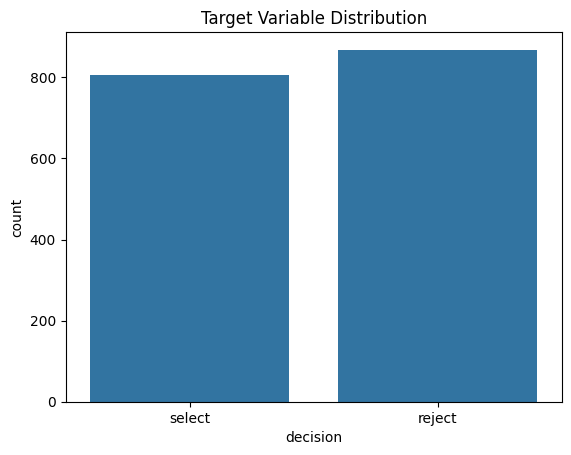

In [ ]:
# Plot Target Variable Distribution
sns.countplot(x='decision', data=data)
plt.title("Target Variable Distribution")
plt.show()


In [ ]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
Unnamed: 0                 0
ID                         0
Name                       0
Role                       0
Transcript                 0
Resume                     0
decision                   0
Reason for decision        0
Job Description            0
num_words_in_transcript    0
dtype: int64


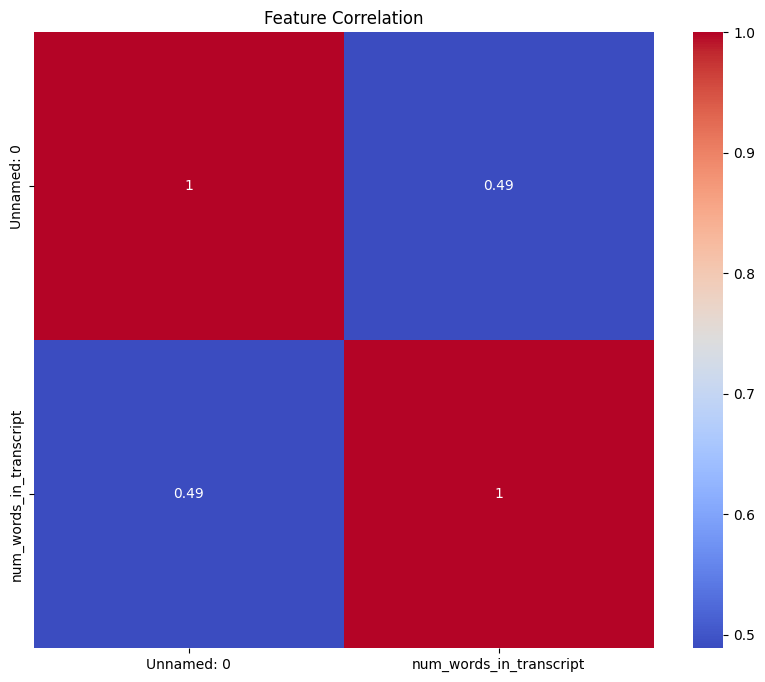

In [ ]:
# Correlation heatmap (only for numerical features)
plt.figure(figsize=(10, 8))
# Select only numerical features for correlation calculation
numerical_data = data.select_dtypes(include=np.number)
sns.heatmap(numerical_data.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()

# Step 2: Preprocessing


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download the 'punkt_tab' resource
nltk.download('punkt_tab')

# Rest of the code remains the same

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Define Helper Classes

In [ ]:
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def clean_text(self, text):
        if pd.isna(text):
            return ""
        text = str(text).lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        tokens = word_tokenize(text)
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens if token not in self.stop_words]
        return ' '.join(tokens)

class FeatureExtractor:
    def __init__(self):
        self.tfidf = TfidfVectorizer(max_features=5000)
        self.svd = TruncatedSVD(n_components=50)

    def extract_features(self, resume, jd, transcript):
        features = {}

        # TF-IDF and similarities
        tfidf_matrix = self.tfidf.fit_transform([resume, jd, transcript])
        features['resume_jd_similarity'] = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0, 0]
        features['resume_transcript_similarity'] = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[2:3])[0, 0]

        # Sentiment analysis
        features['resume_sentiment_polarity'] = TextBlob(resume).sentiment.polarity
        features['jd_sentiment_polarity'] = TextBlob(jd).sentiment.polarity

        # Text statistics
        features['resume_length'] = len(resume.split())
        features['jd_length'] = len(jd.split())

        # Skills matching
        skills = ['python', 'machine learning', 'data analysis', 'sql', 'deep learning']
        resume_skills = sum(skill in resume.lower() for skill in skills)
        jd_skills = sum(skill in jd.lower() for skill in skills)
        features['skills_match_count'] = resume_skills
        features['skills_match_ratio'] = resume_skills / jd_skills if jd_skills > 0 else 0

        return features


In [ ]:
# Upload your dataset
from google.colab import files
uploaded = files.upload()

# Load data
filename = next(iter(uploaded))
data = pd.read_excel(filename)

# Initialize preprocessor and feature extractor
preprocessor = TextPreprocessor()
feature_extractor = FeatureExtractor()

# Preprocess text
data['clean_resume'] = data['Resume'].apply(preprocessor.clean_text)
data['clean_jd'] = data['Job Description'].apply(preprocessor.clean_text)
data['clean_transcript'] = data['Transcript'].apply(preprocessor.clean_text)

# Extract features
features = []
for _, row in data.iterrows():
    features.append(feature_extractor.extract_features(row['clean_resume'], row['clean_jd'], row['clean_transcript']))

X = pd.DataFrame(features)
y = data['decision'].map({'select': 1, 'reject': 0})


Saving dataset_1_2_3_combined (1).xlsx to dataset_1_2_3_combined (1) (3).xlsx


# Train-Test Split

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Hyperparameter Tuning and Model Training

In [ ]:
!pip install scikit-learn==1.2.2

In [ ]:
!pip install --upgrade xgboost

In [ ]:
# Define models and parameter grids
models = {
    'Logistic Regression': (
        LogisticRegression(random_state=42, max_iter=1000),
        {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
    ),
    'Decision Tree': (
        DecisionTreeClassifier(random_state=42),
        {'max_depth': [5, 10, 20], 'min_samples_split': [2, 5, 10]}
    ),
    'Random Forest': (
        RandomForestClassifier(random_state=42),
        {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, None]}
    ),
    'XGBoost': (
        XGBClassifier(random_state=42, use_label_encoder=False),
        {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1]}
    )
}

# Train and tune models
best_models = {}
for name, (model, params) in models.items():
    print(f"Tuning {name}...")
    grid_search = GridSearchCV(model, params, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")


Tuning Logistic Regression...
Best parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Tuning Decision Tree...
Best parameters for Decision Tree: {'max_depth': 5, 'min_samples_split': 10}
Tuning Random Forest...
Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 50}
Tuning XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:09:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


# Model Evaluation

In [ ]:
# Evaluate models
for name, model in best_models.items():
    print(f"\nEvaluating {name}...")
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))



Evaluating Logistic Regression...
Accuracy: 0.758
ROC AUC: 0.860

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.75      0.76       174
           1       0.74      0.76      0.75       161

    accuracy                           0.76       335
   macro avg       0.76      0.76      0.76       335
weighted avg       0.76      0.76      0.76       335


Evaluating Decision Tree...
Accuracy: 0.791
ROC AUC: 0.887

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       174
           1       0.75      0.84      0.79       161

    accuracy                           0.79       335
   macro avg       0.79      0.79      0.79       335
weighted avg       0.80      0.79      0.79       335


Evaluating Random Forest...
Accuracy: 0.764
ROC AUC: 0.890

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.77

#  Post-Model Analysis

In [ ]:
# Logistic Regression Analysis with statsmodels
import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train_scaled)
logit_model = sm.Logit(y_train, X_train_sm)
logit_results = logit_model.fit()
print("\nLogistic Regression Summary:")
print(logit_results.summary())

Optimization terminated successfully.
         Current function value: 0.469399
         Iterations 7

Logistic Regression Summary:
                           Logit Regression Results                           
Dep. Variable:               decision   No. Observations:                 1339
Model:                          Logit   Df Residuals:                     1330
Method:                           MLE   Df Model:                            8
Date:                Sun, 05 Jan 2025   Pseudo R-squ.:                  0.3221
Time:                        13:12:17   Log-Likelihood:                -628.53
converged:                       True   LL-Null:                       -927.23
Covariance Type:            nonrobust   LLR p-value:                8.457e-124
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1877      0.075     -2.508      0.012      -0.334      -0.041

In [ ]:
# Feature importance for Random Forest


Feature Importance for Random Forest:
                        Feature  Importance
2     resume_sentiment_polarity    0.270599
0          resume_jd_similarity    0.179409
3         jd_sentiment_polarity    0.178465
1  resume_transcript_similarity    0.122983
4                 resume_length    0.105358
5                     jd_length    0.071203
7            skills_match_ratio    0.036110
6            skills_match_count    0.035873


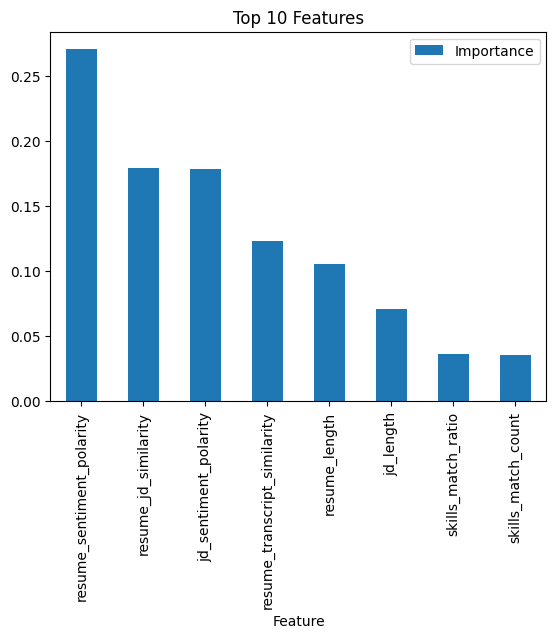

In [ ]:
if 'Random Forest' in best_models:
    rf_model = best_models['Random Forest']
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    print("\nFeature Importance for Random Forest:")
    print(feature_importances)
    feature_importances.head(10).plot(kind='bar', x='Feature', y='Importance', title='Top 10 Features')